In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns',None)

In [2]:
traffic = pd.read_excel("dataset/traffic_data_2013-23.xlsx")
weather = pd.read_excel("dataset/weather_data_2013-23.xlsx")

print(traffic.shape, weather.shape)

(290705, 5) (86184, 8)


### Traffic EDA

In [3]:
traffic.head()

,Site Name,Report Date,Time Period Ending,Avg mph,Total Volume
0,7004/1,2013-06-01T00:00:00,00:59:00,NaN,69.0
1,7004/1,2013-06-01T00:00:00,01:59:00,NaN,33.0
2,7004/1,2013-06-01T00:00:00,02:59:00,NaN,23.0
3,7004/1,2013-06-01T00:00:00,03:59:00,NaN,24.0
4,7004/1,2013-06-01T00:00:00,04:59:00,NaN,26.0


In [4]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290705 entries, 0 to 290704
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Site Name           290705 non-null  object 
 1   Report Date         290705 non-null  object 
 2   Time Period Ending  290705 non-null  object 
 3   Avg mph             255650 non-null  float64
 4   Total Volume        271224 non-null  float64
dtypes: float64(2), object(3)
memory usage: 11.1+ MB


In [5]:
traffic.isnull().mean()*100

Site Name              0.000000
Report Date            0.000000
Time Period Ending     0.000000
Avg mph               12.058616
Total Volume           6.701295
dtype: float64

In [6]:
traffic['Date'] = pd.to_datetime(traffic['Report Date'])
traffic['Hour'] = pd.to_timedelta(traffic['Time Period Ending'].str.slice(0, 2) + ':00:00')
traffic['Datetime'] = traffic['Date'] + traffic['Hour']

In [7]:
traffic.drop(['Site Name','Report Date','Time Period Ending','Avg mph','Date','Hour'], axis=1, inplace=True)

In [53]:
agg_traffic = traffic.groupby('Datetime')['Total Volume'].sum().reset_index()

In [54]:
agg_traffic.head()

,Datetime,Total Volume
0,2013-06-01 00:00:00,69.0
1,2013-06-01 01:00:00,33.0
2,2013-06-01 02:00:00,23.0
3,2013-06-01 03:00:00,24.0
4,2013-06-01 04:00:00,26.0


In [55]:
agg_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84349 entries, 0 to 84348
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Datetime      84349 non-null  datetime64[ns]
 1   Total Volume  84349 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.3 MB


In [56]:
agg_traffic = agg_traffic.set_index('Datetime')
date_range = pd.date_range(start=agg_traffic.index.min(), end=agg_traffic.index.max(), freq='H')
agg_traffic = agg_traffic.reindex(date_range, fill_value=np.nan)
agg_traffic.index.names = ['Datetime']

In [59]:
agg_traffic.isnull().sum()

Total Volume    1836
dtype: int64

In [61]:
agg_traffic[agg_traffic['Total Volume'].isnull()]

,Total Volume
Datetime,
2013-07-01 01:00:00,NaN
2013-07-01 02:00:00,NaN
2013-07-01 03:00:00,NaN
2013-07-01 04:00:00,NaN
2013-07-01 05:00:00,NaN
...,...
2021-05-24 22:00:00,NaN
2021-05-24 23:00:00,NaN
2021-05-25 00:00:00,NaN


<AxesSubplot:title={'center':'Distribution of Traffic'}, ylabel='Frequency'>

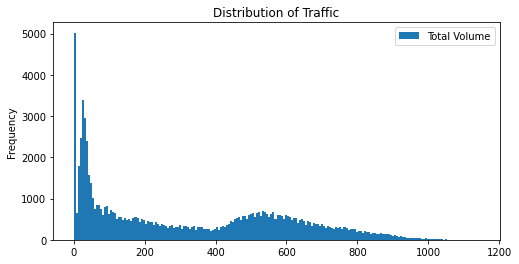

In [62]:
agg_traffic.plot.hist(figsize=(8,4), bins=200, title="Distribution of Traffic")

<AxesSubplot:title={'center':'Road Traffic 2013-2023'}, xlabel='Datetime'>

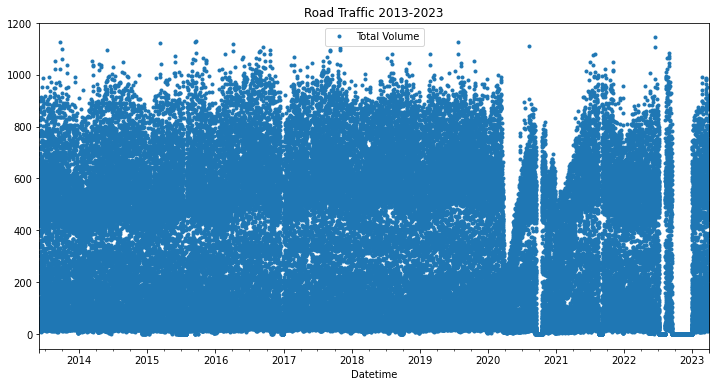

In [63]:
agg_traffic.plot(style='.', figsize=(12,6),  title="Road Traffic 2013-2023")

<AxesSubplot:title={'center':'Seasonality on Daily Basis'}, xlabel='Datetime'>

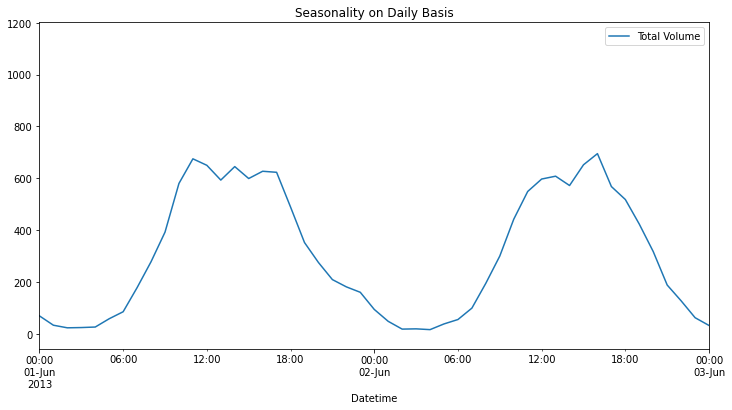

In [64]:
agg_traffic.plot(xlim=['2013-06-01 00:00:00','2013-06-03 00:00:00'], figsize=(12,6), title="Seasonality on Daily Basis")

<AxesSubplot:title={'center':'Seasonality on Weekly Basis'}, xlabel='Datetime'>

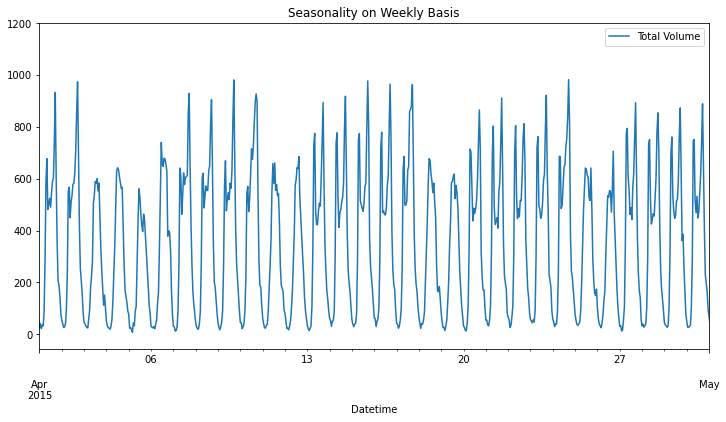

In [65]:
agg_traffic.plot(xlim=['2015-04-01 00:00:00','2015-05-01 00:00:00'], figsize=(12,6), title="Seasonality on Weekly Basis")

<AxesSubplot:title={'center':'Seasonality on Monthly Basis'}, xlabel='Datetime'>

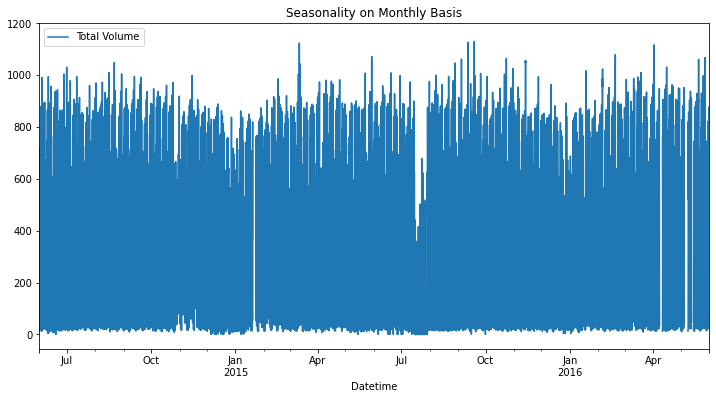

In [66]:
agg_traffic.plot(xlim=['2014-06-01 00:00:00','2016-06-01 00:00:00'], figsize=(12,6), title="Seasonality on Monthly Basis")

We can infer following points:
1. The traffic data rises during 12pm-6pm (peak hours) & falls to almost zero during midnight and morning.
2. Traffic is high during the weekdays, compared to the weekends.
3. There is less traffic in winters as compared to summers.

So we can say that the data is seasonal but has no trend. This will be helpful.

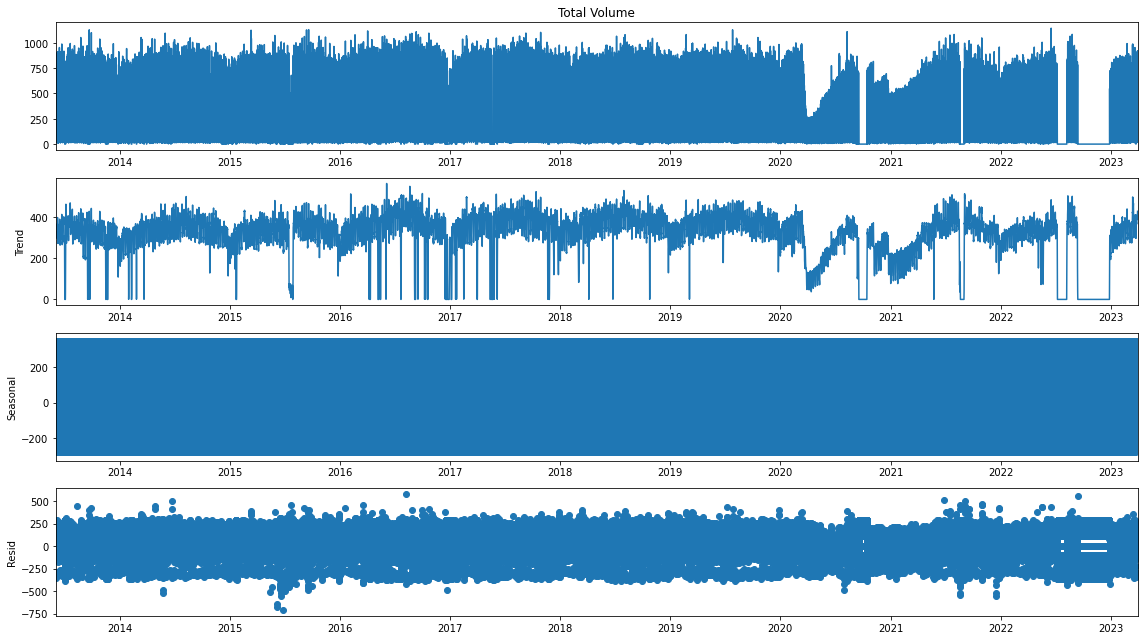

In [68]:
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose

agg_copy = agg_traffic.copy().fillna(0)
result = seasonal_decompose(agg_copy['Total Volume'], model='additive', period=24)

fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

There are a lot of missing values. So we have to figure out a way of handling it. We can see that post 2020 the missing values gaps are high. Also the COVID has had affects on traffic due to lockdown. So in this project, we will remove data post 2020 and will try to forecast in a non pandemic scenario.

In [69]:
df = agg_traffic.copy()

In [70]:
df = df[df.index < "2020-01-01 00:00:00"]

In [71]:
df

,Total Volume
Datetime,
2013-06-01 00:00:00,69.0
2013-06-01 01:00:00,33.0
2013-06-01 02:00:00,23.0
2013-06-01 03:00:00,24.0
2013-06-01 04:00:00,26.0
...,...
2019-12-31 19:00:00,194.0
2019-12-31 20:00:00,134.0
2019-12-31 21:00:00,71.0


<AxesSubplot:title={'center':'Road Traffic 2013-2019'}, xlabel='Datetime'>

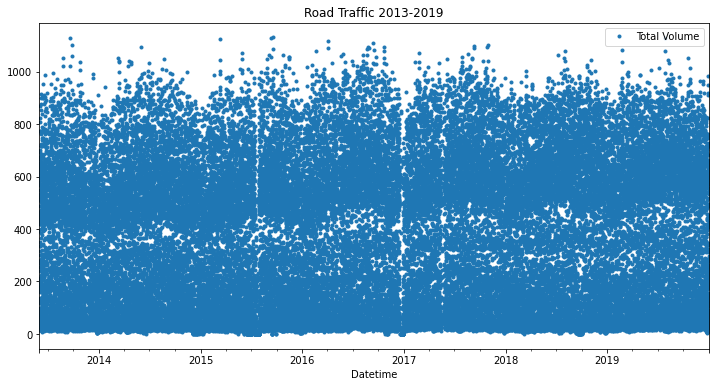

In [72]:
df.plot(style='.', figsize=(12,6),  title="Road Traffic 2013-2019")

In [82]:
unique_dates = np.unique(df[df['Total Volume'].isnull()].index.date)

max_consecutive_days = 0
current_consecutive_days = 0

for i in range(1, len(unique_dates)):
    if (unique_dates[i] - unique_dates[i - 1]).days == 1:
        current_consecutive_days += 1
    else:
        max_consecutive_days = max(max_consecutive_days, current_consecutive_days)
        current_consecutive_days = 0
        
print("Max number of consecutive missing days are: ",max_consecutive_days)

Max number of consecutive missing days are:  10


We have to fill max 10 days of data using some handling techniques. Since the data is huge, it shouldn't be a problem to use ffill or bfill or interpolation techniques. We'll try all and choose the best.

In [83]:
df.isnull().sum()

Total Volume    1808
dtype: int64

In [91]:
df[df['Total Volume']==0]

,Total Volume
Datetime,
2014-06-19 00:00:00,0.0
2014-12-04 23:00:00,0.0
2014-12-10 01:00:00,0.0
2014-12-11 03:00:00,0.0
2014-12-18 03:00:00,0.0
...,...
2016-12-28 15:00:00,0.0
2018-09-22 01:00:00,0.0
2018-09-25 00:00:00,0.0


#### ----> interpolation

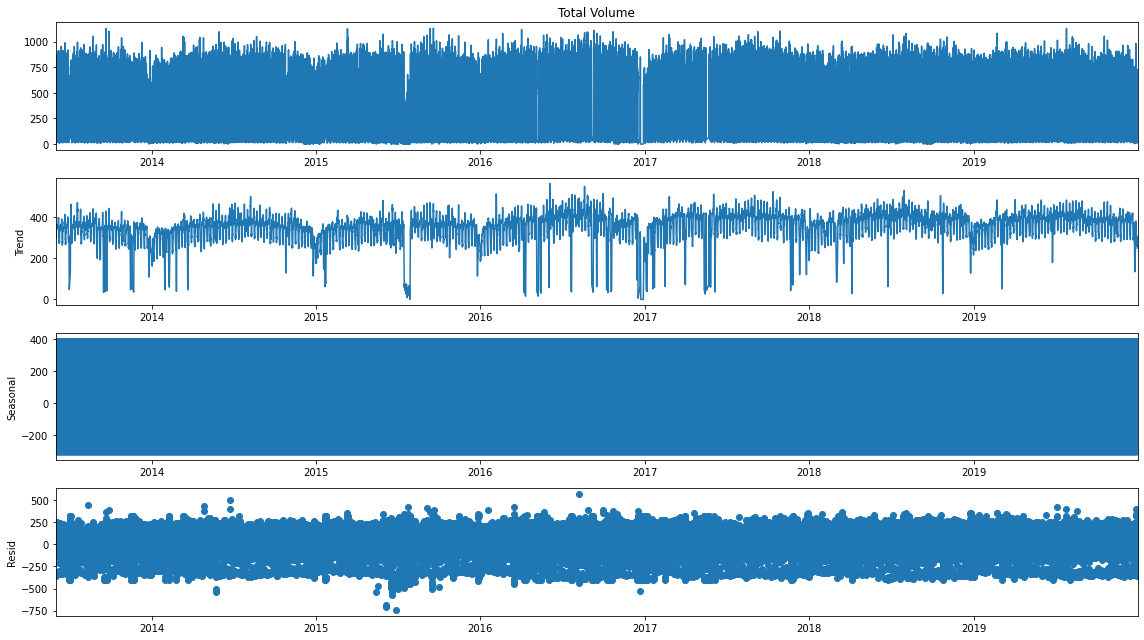

In [96]:
interpolation = df.copy()
interpolation['Total Volume'] = df['Total Volume'].interpolate(method='linear')
result = seasonal_decompose(interpolation['Total Volume'], model='additive', period=24)

fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

#### ----> mean imputation

In [135]:
df_mean = df.copy()

weekly_daily_hourly_means = df_mean.groupby([df_mean.index.week, df_mean.index.dayofweek, df_mean.index.hour])['Total Volume'].mean()
df_mean['Total Volume'] = df_mean.apply(lambda row: weekly_daily_hourly_means[(row.name.week, row.name.dayofweek, row.name.hour)] if pd.isna(row['Total Volume']) else row['Total Volume'], axis=1)
df_mean['Total Volume'] = df_mean.apply(lambda row: weekly_daily_hourly_means[(row.name.week, row.name.dayofweek, row.name.hour)] if row['Total Volume'] == 0 else row['Total Volume'], axis=1)

In [136]:
weekly_daily_hourly_means

Datetime  Datetime  Datetime
1         0         0            32.428571
                    1            26.285714
                    2            16.000000
                    3            16.142857
                    4            22.428571
                                   ...    
53        6         19          249.000000
                    20          168.000000
                    21          133.000000
                    22           71.000000
                    23           54.000000
Name: Total Volume, Length: 8904, dtype: float64

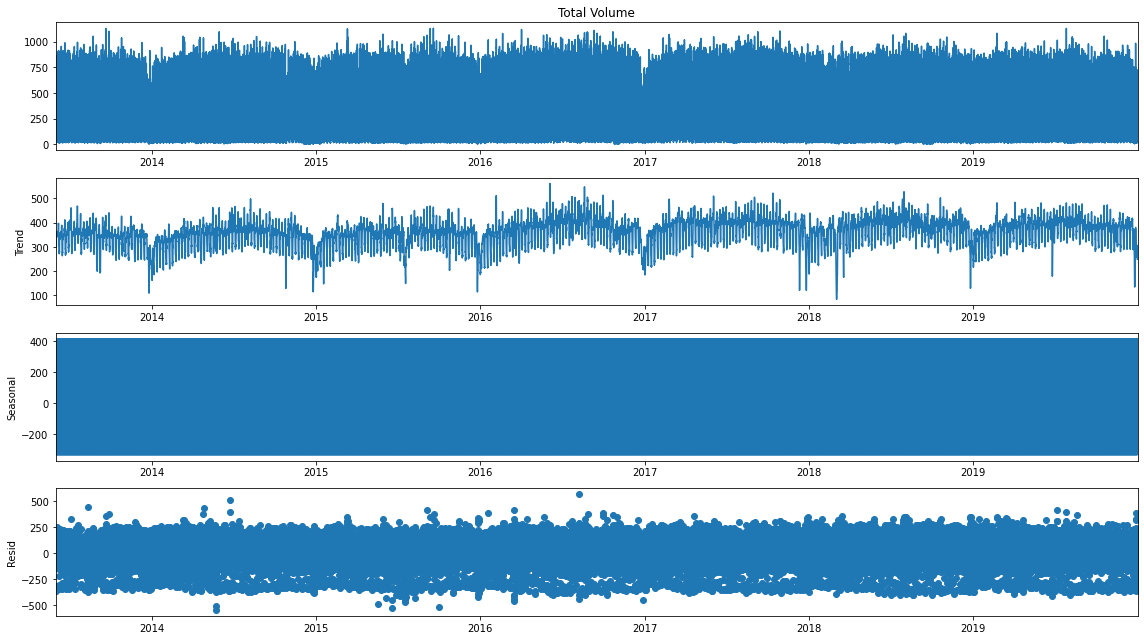

In [137]:
result = seasonal_decompose(df_mean['Total Volume'], model='additive', period=24)
fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Seasonality on Daily Basis'}, xlabel='Datetime'>

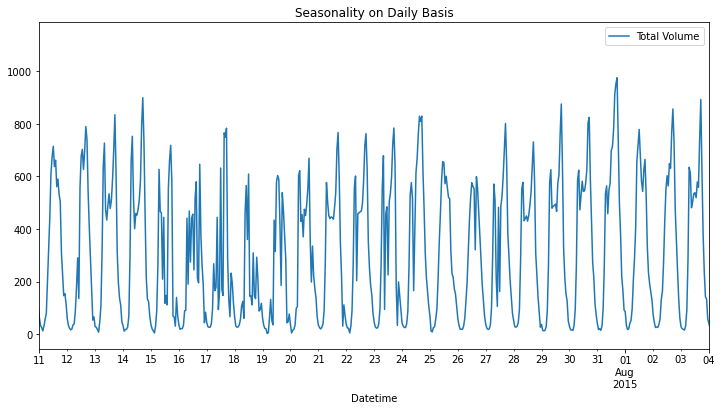

In [138]:
df_mean.plot(xlim=['2015-07-11 00:00:00','2015-08-04 00:00:00'], figsize=(12,6), title="Seasonality on Daily Basis")

<AxesSubplot:title={'center':'Seasonality on Weekly Basis'}, xlabel='Datetime'>

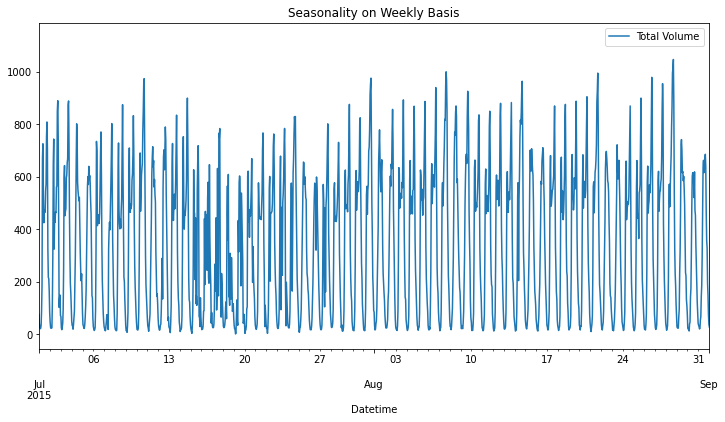

In [139]:
df_mean.plot(xlim=['2015-07-01 00:00:00','2015-09-01 00:00:00'], figsize=(12,6), title="Seasonality on Weekly Basis")

In [134]:
df_mean[df_mean['Total Volume']==0]

,Total Volume
Datetime,
2014-06-19 00:00:00,0.0
2014-12-04 23:00:00,0.0
2014-12-10 01:00:00,0.0
2014-12-11 03:00:00,0.0
2014-12-18 03:00:00,0.0
...,...
2016-12-28 15:00:00,0.0
2018-09-22 01:00:00,0.0
2018-09-25 00:00:00,0.0


In [108]:
b.loc['2013-07-01 04:00:00']

Total Volume    38.269461
Name: 2013-07-01 04:00:00, dtype: float64

### Weather EDA

In [15]:
weather.head()

,time,temperature_2m,relativehumidity_2m,precipitation,rain,snowfall,weathercode,windspeed_10m
0,2013-06-01T00:00,11.7,78,0.0,0.0,0.0,1,18.5
1,2013-06-01T01:00,10.9,80,0.0,0.0,0.0,0,17.9
2,2013-06-01T02:00,10.2,81,0.0,0.0,0.0,0,17.6
3,2013-06-01T03:00,9.5,80,0.0,0.0,0.0,0,16.7
4,2013-06-01T04:00,8.9,79,0.0,0.0,0.0,0,16.1


In [16]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86184 entries, 0 to 86183
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 86184 non-null  object 
 1   temperature_2m       86184 non-null  float64
 2   relativehumidity_2m  86184 non-null  int64  
 3   precipitation        86184 non-null  float64
 4   rain                 86184 non-null  float64
 5   snowfall             86184 non-null  float64
 6   weathercode          86184 non-null  int64  
 7   windspeed_10m        86184 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 5.3+ MB


<AxesSubplot:title={'center':'Distribution of Traffic'}, ylabel='Frequency'>

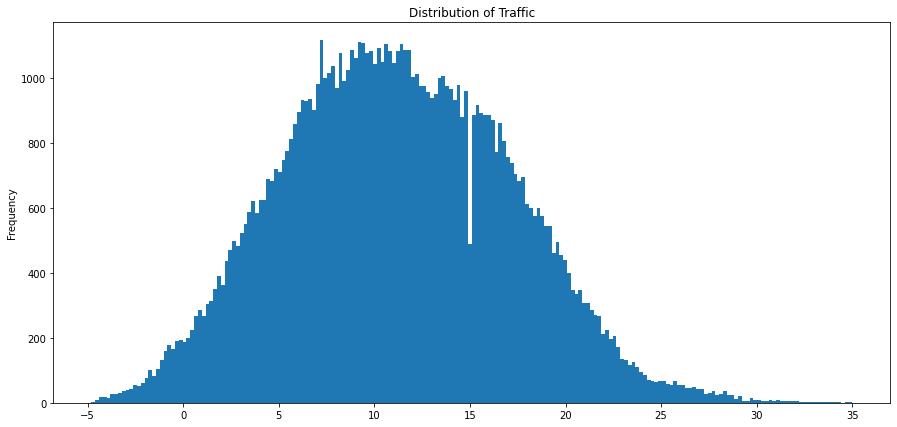

In [18]:
weather['temperature_2m'].plot.hist(figsize=(15,7), bins=200, title="Distribution of Traffic")

In [25]:
weather['time'] = pd.to_datetime(weather['time'])
agg_weather = weather.set_index('time')

In [36]:
# df = pd.merge(agg_traffic, agg_weather, left_index=True, right_index=True)
# df = df.reset_index().set_index('time')
# print(agg_traffic.shape, agg_weather.shape, df.shape)

In [34]:
df.head()

,Total Volume,temperature_2m,relativehumidity_2m,precipitation,rain,snowfall,weathercode,windspeed_10m
index,,,,,,,,
2013-06-01 00:00:00,69.0,11.7,78,0.0,0.0,0.0,1,18.5
2013-06-01 01:00:00,33.0,10.9,80,0.0,0.0,0.0,0,17.9
2013-06-01 02:00:00,23.0,10.2,81,0.0,0.0,0.0,0,17.6
2013-06-01 03:00:00,24.0,9.5,80,0.0,0.0,0.0,0,16.7
2013-06-01 04:00:00,26.0,8.9,79,0.0,0.0,0.0,0,16.1


In [30]:
test_df = df[df['Total Volume']==0]
train_df = df[df['Total Volume']!=0]

print(train_df.shape, test_df.shape)

(79535, 8) (6649, 8)


In [32]:
test_df.head()

,Total Volume,temperature_2m,relativehumidity_2m,precipitation,rain,snowfall,weathercode,windspeed_10m
2013-07-01 01:00:00,0.0,12.8,86,0.0,0.0,0.0,1,14.1
2013-07-01 02:00:00,0.0,12.6,89,0.0,0.0,0.0,1,13.9
2013-07-01 03:00:00,0.0,12.4,90,0.0,0.0,0.0,2,13.7
2013-07-01 04:00:00,0.0,12.5,89,0.0,0.0,0.0,2,13.9
2013-07-01 05:00:00,0.0,12.9,86,0.0,0.0,0.0,3,13.6


In [23]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import DatetimeTickFormatter

output_notebook()

p = figure(title='Time Series Data', x_axis_label='Datetime', y_axis_label='Total Volume', 
           x_axis_type='datetime', plot_width=800, plot_height=400)

p.line(agg_traffic.index, agg_traffic['Total Volume'], line_width=2)

p.xaxis.formatter = DatetimeTickFormatter()
p.xaxis.major_label_orientation = 45

show(p)

Loading BokehJS ...